Лабораторная работа №1.

Недосеков И.Д.,группа М8О-306Б-19

## Задание
Формально говоря вам предстоит сделать следующее:

1) реализовать следующие алгоритмы машинного обучения: Linear/ Logistic Regression, SVM, KNN, Naive Bayes в отдельных классах

2) Данные классы должны наследоваться от BaseEstimator и ClassifierMixin, иметь методы fit и predict (подробнее: https://scikit-learn.org/stable/developers/develop.html )

3) Вы должны организовать весь процесс предобработки, обучения и тестирования с помощью Pipeline (подробнее: https://scikit-learn.org/stable/modules/compose.html)

4) Вы должны настроить гиперпараметры моделей с помощью кросс валидации (GridSearchCV,RandomSearchCV, подробнее здесь: https://scikit-learn.org/stable/modules/grid_search.html), вывести и сохранить эти гиперпараметры в файл, вместе с обученными моделями

5) Проделать аналогично с коробочными решениями

6) Для каждой модели получить оценки метрик:Confusion Matrix, Accuracy, Recall, Precision, ROC_AUC curve (подробнее: Hands on machine learning with python and scikit learn chapter 3, mlcourse.ai, https://ml-handbook.ru/chapters/model_evaluation/intro)

7) Проанализировать полученные результаты и сделать выводы о применимости моделей

8) Загрузить полученные гиперпараметры модели и обученные модели в формате pickle на гит вместе с jupyter notebook ваших экспериментов

## Подготовленный датасет

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)


In [28]:
dataset = pd.read_csv('./prepared_dataset.csv')
dataset.head()

,gender,age,height(cm),weight(kg),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar,smoking
0,0,40,155,60,1.2,1.0,1.0,1.0,114.0,73.0,94.0,82.0,73.0,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0,1,0
1,0,40,160,60,0.8,0.6,1.0,1.0,119.0,70.0,130.0,115.0,42.0,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0,1,0
2,1,55,170,60,0.8,0.8,1.0,1.0,138.0,86.0,89.0,182.0,55.0,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0,0,1
3,0,40,155,60,1.0,1.0,1.0,1.0,120.0,74.0,80.0,74.0,62.0,107.0,12.5,1.0,0.6,16.0,14.0,22.0,0,0,0
4,1,30,180,75,1.2,1.2,1.0,1.0,128.0,76.0,95.0,199.0,48.0,129.0,16.2,1.0,1.2,18.0,27.0,33.0,0,1,0


In [12]:
dataset.dtypes

gender                   int64
age                      int64
height(cm)               int64
weight(kg)               int64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)          float64
hearing(right)         float64
systolic               float64
relaxation             float64
fasting blood sugar    float64
triglyceride           float64
HDL                    float64
LDL                    float64
hemoglobin             float64
Urine protein          float64
serum creatinine       float64
AST                    float64
ALT                    float64
Gtp                    float64
dental caries            int64
tartar                   int64
smoking                  int64
dtype: object

In [56]:
numeric_columns = [
    'age', 'height(cm)', 'weight(kg)',
    'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)',
    'systolic', 'relaxation', 'fasting blood sugar',
    'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein',
    'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries'
]
category_columns = ['gender', 'tartar']
target_column = ['smoking']

Разделим датасет на target тренировочную выборку. Разобьем тренировочную выборку.

In [96]:
X = dataset.drop(columns=target_column)
y = dataset[target_column]

data_train, data_test, target_train, target_test = train_test_split(X, y, train_size=0.8, random_state=42)

## Logistic Regression

In [90]:
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve, plot_confusion_matrix
from sklearn.compose import ColumnTransformer
import pickle

In [92]:
class MyLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(
        self,  
        lr: float = 1e-2, 
        C: float = 1.0,
        batch_size: int = 32, 
        bound: float = 0.5,
        max_iter: int = 100
    ) -> None:
        self.lr = lr
        self.C = C
        self.batch_size = batch_size
        self.bound = bound
        self.max_iter = max_iter

    @staticmethod
    def sigmoid(v: np.ndarray):
        return 1.0 / (1.0 + np.exp(-v))

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y

        w = np.random.normal(size=(self.X_.shape[1], ))
        b = 0.0

        for _ in range(self.max_iter):
            for batch_start in range(0, len(self.X_), self.batch_size):
                batch_end = batch_start + self.batch_size
                batch_X = self.X_[batch_start:batch_end]
                batch_y = self.y_[batch_start:batch_end]
                sigmoid_val = self.sigmoid(batch_X @ w + b)
                w -= (self.lr * batch_X.T @ (sigmoid_val - batch_y) + w / self.C) / self.batch_size
                b -= self.lr * np.sum(sigmoid_val - batch_y) / self.batch_size

        self.w = w
        self.b = b
        return self

    def decision_function(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return X @ self.w + self.b

    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return self.sigmoid(X @ self.w + self.b)

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        sigmoid_val = self.predict_proba(X)
        return np.where(sigmoid_val > self.bound, 1, 0 )

In [93]:
cv_num = 5
logreg_prefix = 'mylogisticregression__'

pipe = make_pipeline(
    ColumnTransformer([('cat', OneHotEncoder(sparse=False, handle_unknown="ignore"), category_columns)]),
    MyLogisticRegression()
)

param_grid = {
    logreg_prefix + "lr": [1e-04, 1e-03, 1e-02],
    logreg_prefix + "batch_size": [32, 64],
    logreg_prefix + "C": [1e-1, 1.0, 10.0]
}
CV_model = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_num,
    scoring="accuracy",
    verbose=0,
    refit=True
)

In [94]:
CV_model.fit(data_train, target_train)

C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['gender',
                                                                          'tartar'])])),
                                       ('mylogisticregression',
                                        MyLogisticRegression())]),
             param_grid={'mylogisticregression__C': [0.1, 1.0, 10.0],
                         'mylogisticregression__batch_size': [32, 64],
                         'mylogisticregression__lr': [0.0001, 0.001, 0.01]},
             scoring='accuracy')

In [26]:
CV_model.best_params_

{'mylogisticregression__C': 0.1,
 'mylogisticregression__batch_size': 64,
 'mylogisticregression__lr': 0.0001}

C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


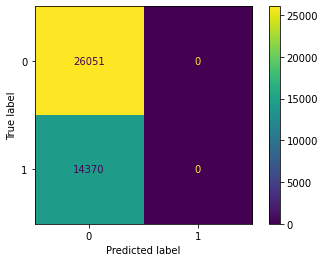

In [33]:
plot_confusion_matrix(CV_model, data_train, target_train)

C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


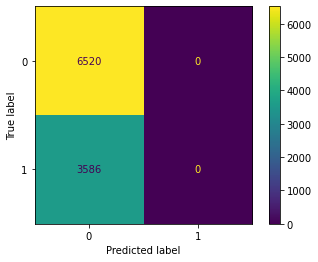

In [34]:
plot_confusion_matrix(CV_model, data_test, target_test)

In [ ]:
target_train_predicted = CV_model.predict_proba(data_train)
target_test_predicted = CV_model.predict_proba(data_test)

train_auc = roc_auc_score(target_train, target_train_predicted)
test_auc = roc_auc_score(target_test, target_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(target_train, target_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(target_test, target_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

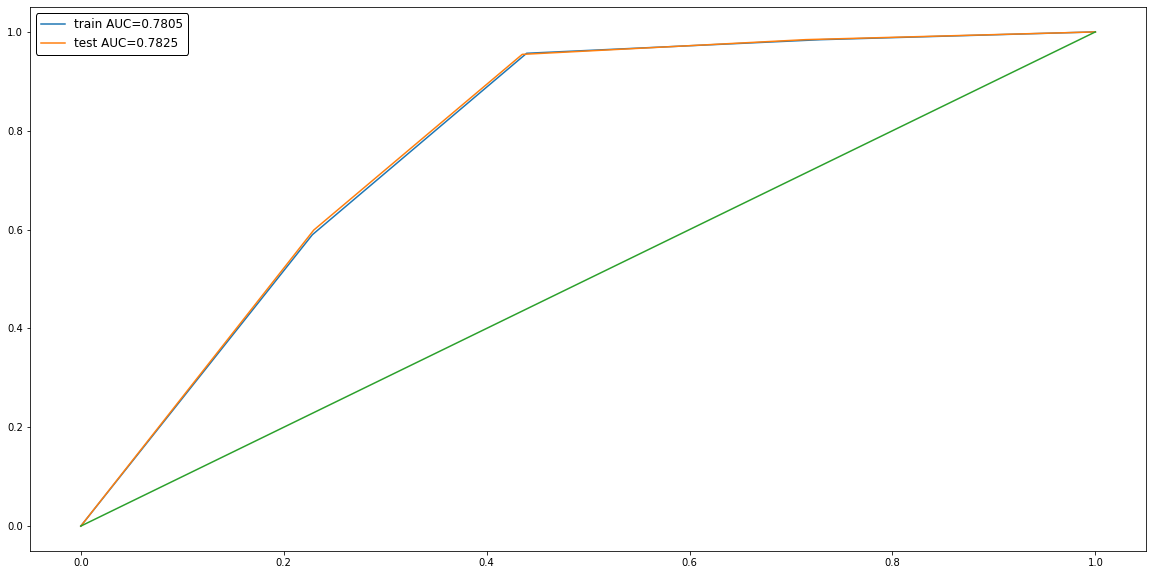

In [99]:
target_train_predicted = CV_model.predict_proba(data_train)
target_test_predicted = CV_model.predict_proba(data_test)

train_auc = roc_auc_score(target_train, target_train_predicted)
test_auc = roc_auc_score(target_test, target_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(target_train, target_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(target_test, target_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [100]:
with open('my_logreg.pkl', 'wb') as f:
    pickle.dump(CV_model.best_estimator_, f)

In [35]:
cv_num = 5

encoder = prep_pipeline = ColumnTransformer([
        ('cat', OneHotEncoder(sparse=False, handle_unknown="ignore"), category_columns)
])
pipe = make_pipeline(
    encoder,
    LogisticRegression()
)

param_grid = {
    "logisticregression__penalty": ["l2"],
    "logisticregression__C": [1e-1, 1.0, 10.0],
    "logisticregression__solver": ["lbfgs", "newton-cg", "sag"],
    "logisticregression__max_iter": [100, 300],
    "logisticregression__tol": [1e-2, 1e-3]
}
CV_model = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_num,
    scoring="roc_auc",
    verbose=0,
    refit=True
)

In [36]:
CV_model.fit(data_train, target_train)

C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['gender',
                                                                          'tartar'])])),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.1, 1.0, 10.0],
                         'logisticregression__max_iter': [100, 300],
                         'logisticregression__penalty': ['l2'],
                         'logisticregression__solver': ['lbfgs', 'newton-cg',
                                               

C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


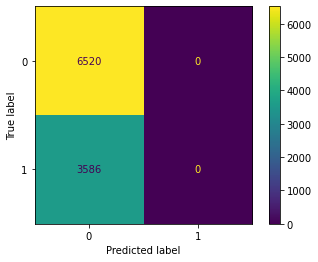

In [104]:
plot_confusion_matrix(CV_model, data_test, target_test)

In [38]:
from scipy.stats import norm

In [39]:
class MyNaiveBayes(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        X, y = check_X_y(X, y)

        self.unique_labels = np.unique(y)
        self.X_ = X
        self.y_ = y    
        self.smooth = 1e-3 

        self.X_depends_on_Y = {} 
        for label in self.unique_labels:
            distributions = []
            for i in range(X.shape[1]):
                feature = X[y == label, i].flatten()
                distributions.append(norm(loc=feature.mean(), scale=(feature.std() + self.smooth)))
            self.X_depends_on_Y[label] = distributions

        self.Y_probs = {label: sum((y == label)).astype(float) / len(y) for label in self.unique_labels}
    
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        probs = np.zeros((X.shape[0], len(self.unique_labels)), dtype=float)
        X_probs = np.ones((X.shape[0], len(self.unique_labels)), dtype=float)


        for i, label in enumerate(self.unique_labels):
            for j in range(X.shape[1]):
                probs[:, i] += np.log(self.X_depends_on_Y[label][j].pdf(X[:, j]) + self.smooth)
            probs[:, i] += np.log(self.Y_probs[label] + self.smooth)

        return np.array(probs.argmax(axis=1))

In [40]:
cv_num = 5

encoder = ColumnTransformer([
        ('cat', OneHotEncoder(sparse=False, handle_unknown="ignore"), category_columns)
])
pipe = make_pipeline(
    encoder,
    MyNaiveBayes()
)

param_grid = dict()

CV_model = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_num,
    scoring="accuracy",
    verbose=0,
    refit=True
)

In [41]:
CV_model.fit(data_train, target_train)

C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['gender',
                                                                          'tartar'])])),
                                       ('mynaivebayes', MyNaiveBayes())]),
             param_grid={}, scoring='accuracy')

C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


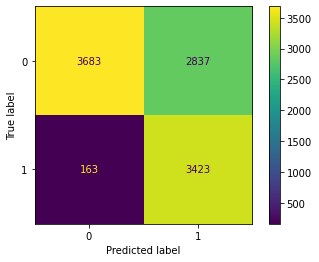

In [42]:
plot_confusion_matrix(CV_model, data_test, target_test)

In [43]:
from sklearn.naive_bayes import GaussianNB

In [44]:
cv_num = 5

encoder = prep_pipeline = ColumnTransformer([
        ('cat', OneHotEncoder(sparse=False, handle_unknown="ignore"), category_columns)
])
pipe = make_pipeline(
    encoder,
    GaussianNB()
)

param_grid = dict()
CV_model = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_num,
    scoring="accuracy",
    verbose=0,
    refit=True
)

In [48]:
CV_model.fit(data_train, target_train)

C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['gender',
                                                                          'tartar'])])),
                                       ('gaussiannb', GaussianNB())]),
             param_grid={}, scoring='accuracy')

C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


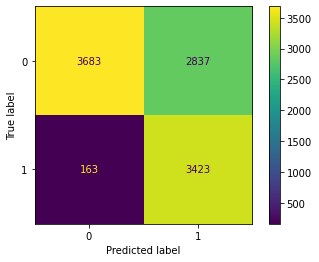

In [49]:
plot_confusion_matrix(CV_model, data_test, target_test)

C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


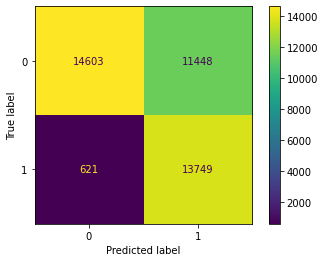

In [50]:
plot_confusion_matrix(CV_model, data_train, target_train)

In [52]:
class MyKNN(BaseEstimator, ClassifierMixin):
    def __init__(
        self,  
        nn: int = 5,
        w: str = "uniform"
        ):
        self.nn = nn
        self.w = w

    def fit(self, X, y):
         X, y = check_X_y(X, y)
         self.X_ = X
         self.y_ = y
         self.unique_labels = np.unique(y)
         return self

    def get_pred(self, nearest):
        preds = np.zeros(len(self.unique_labels))
        for d, i in nearest:
            if self.w == "distance":
                preds[i] += 1.0 / (d + 1e-08)
            else:
                preds[i] += 1
        return np.argmax(preds)

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        preds = []
        for obj in X:
            dists = []
            for i, obj_to_cmp in enumerate(self.X_):
                dist = np.linalg.norm(obj - obj_to_cmp)
                dists.append((dist, self.y_[i]))
            dists.sort()
            nearest = dists[: self.nn]
            preds.append(self.get_pred(nearest))

        return np.array(preds, dtype=int)

In [85]:
dataset_short = dataset[:5000]
X_short = dataset_short.drop(columns=target_column)
y_short = dataset_short[target_column]
data_train_short, data_test_short, target_train_short, target_test_short = train_test_split(X_short, y_short, train_size=0.8, random_state=42)
cv_num = 2
logreg_prefix = 'myknn__'

encoder = prep_pipeline = ColumnTransformer([
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(sparse=False, handle_unknown="ignore"), category_columns)
])
pipe = make_pipeline(
    encoder,
    MyKNN()
)

param_grid = {
    logreg_prefix + "nn": [3, 5, 7],
    logreg_prefix + "w": ["uniform", "distance"]
}
CV_model = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_num,
    scoring="accuracy",
    verbose=0,
    refit=True
)

In [86]:
CV_model.fit(data_train_short, target_train_short)

C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'height(cm)',
                                                                          'weight(kg)',
                                                                          'eyesight(left)',
                                                                          'eyesight(right)',
                                                                          'hearing(left)',
                                                                          'hearing(right)',
                                                                          'systolic',
                                      

C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


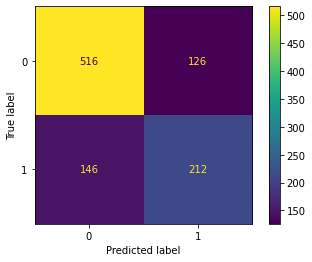

In [88]:
plot_confusion_matrix(CV_model, data_test_short, target_test_short)

In [62]:
from sklearn.neighbors import KNeighborsClassifier

In [64]:
cv_num = 5
encoder = prep_pipeline = ColumnTransformer([
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(sparse=False, handle_unknown="ignore"), category_columns)
])
pipe = make_pipeline(
    encoder,
    KNeighborsClassifier()
)

param_grid = {
    "kneighborsclassifier__n_neighbors": [3, 5, 7],
    "kneighborsclassifier__weights": ["uniform", "distance"]
}
CV_model = GridSearchCV(estimator=pipe,
                        param_grid=param_grid,
                        cv=cv_num,
                        scoring="accuracy",
                        verbose=0,
                        refit=True)

In [65]:
CV_model.fit(data_train, target_train)

C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'height(cm)',
                                                                          'weight(kg)',
                                                                          'eyesight(left)',
                                                                          'eyesight(right)',
                                                                          'hearing(left)',
                                                                          'hearing(right)',
                                                                          'systolic',
                                      

C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


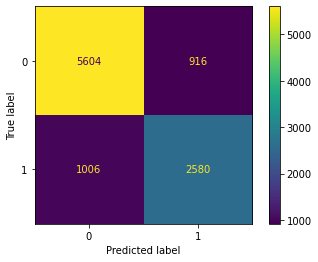

In [66]:
plot_confusion_matrix(CV_model, data_test, target_test)


C:\Users\ivan-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


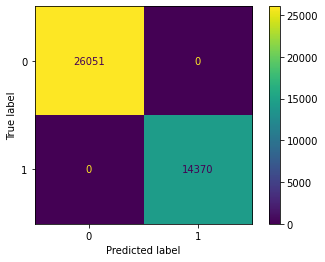

In [67]:
plot_confusion_matrix(CV_model, data_train, target_train)

In [68]:
recall_score(target_test, CV_model.predict(data_test))

0.7194645844952593

In [69]:
recall_score(target_train, CV_model.predict(data_train))

1.0

In [70]:
precision_score(target_test, CV_model.predict(data_test))

0.7379862700228833

In [71]:
precision_score(target_train, CV_model.predict(data_train))

1.0

In [72]:
accuracy_score(target_test, CV_model.predict(data_test))

0.8098159509202454

In [73]:
accuracy_score(target_train, CV_model.predict(data_train))

1.0

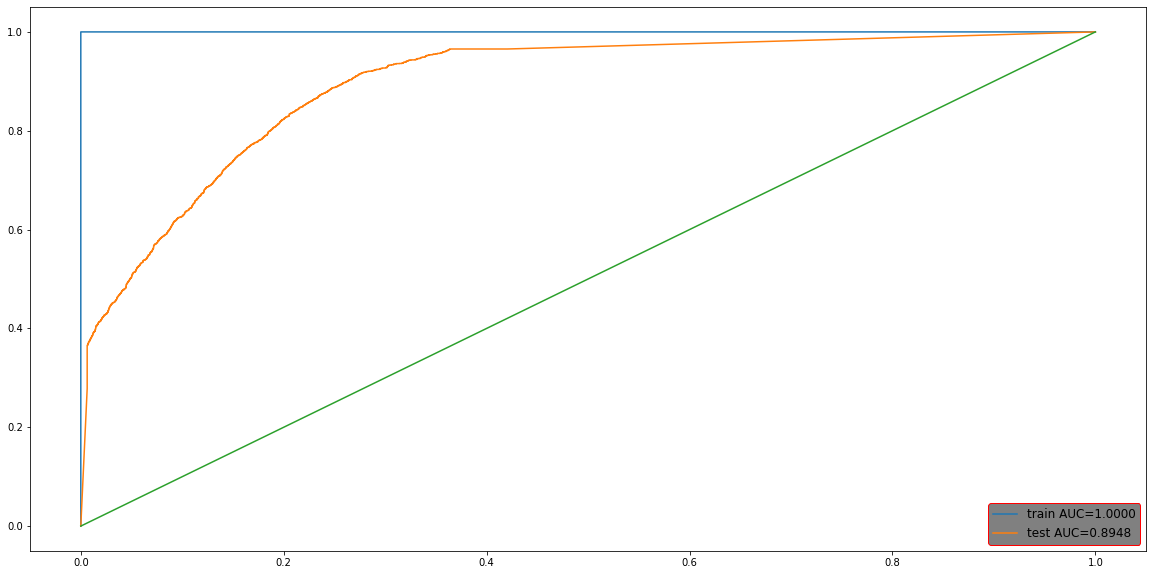

In [ ]:
target_train_predicted = CV_model.predict_proba(data_train)[:, 1]
target_test_predicted = CV_model.predict_proba(data_test)[:, 1]

train_auc = roc_auc_score(target_train, target_train_predicted)
test_auc = roc_auc_score(target_test, target_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(target_train, target_train_predicted)[:2], label='train AUC={:.4%}'.format(train_auc))
plt.plot(*roc_curve(target_test, target_test_predicted)[:2], label='test AUC={:.4%}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_edgecolor("red")
legend_box.set_facecolor("gray")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [75]:
with open('sklearn_knn.pkl', 'wb') as f:
    pickle.dump(CV_model.best_estimator_, f)

In [ ]:
class MySVM(BaseEstimator, ClassifierMixin):
    def __init__(
        self,  
        lr: float = 1e-3,
        C: float = 1.0,
        max_iter: int = 100
):
        self.C = C
        self.lr = lr
        self.max_iter = max_iter

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.labels = np.where(y == 0, -1, 1)

        w = np.random.normal(size=(self.X_.shape[1], ))
        b = 0.0

        for _ in range(self.max_iter):
            for i, obj in enumerate(self.X_):
                if self.labels[i] * (obj @ w + b) >= 1:
                    dw = w / self.C
                    db = 0
                else:
                    dw = w / self.C - self.labels[i] * obj
                    db = -self.labels[i]
                w -= self.lr * dw
                b -= self.lr * db

        self.w = w
        self.b = b
        return self

    def predict(self, X):
        return np.where(np.sign(np.dot(X, self.w) + self.b) == -1, 0, 1)

In [ ]:
cv_num = 5
logreg_prefix = 'mysvm__'

pipe = make_pipeline(
    ColumnTransformer([('cat', OneHotEncoder(sparse=False, handle_unknown="ignore"), category_columns)]),
    MySVM()
)

param_grid = {
    logreg_prefix + "lr": [1e-04, 1e-03, 1e-02],
    logreg_prefix + "C": [1e-1, 1.0, 10.0]
}
CV_model = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_num,
    scoring="accuracy",
    verbose=0,
    refit=True
)

In [ ]:
CV_model.fit(data_train, target_train)

## Вывод

По результатам видно, что наивный баес и knn показывают неплохие результаты, но knn переобучился. Собственные модели в некоторых случаях показывают достойный результат по сравнению с моделями из коробки.